### OpenParse

OpenAI LLM initialized.


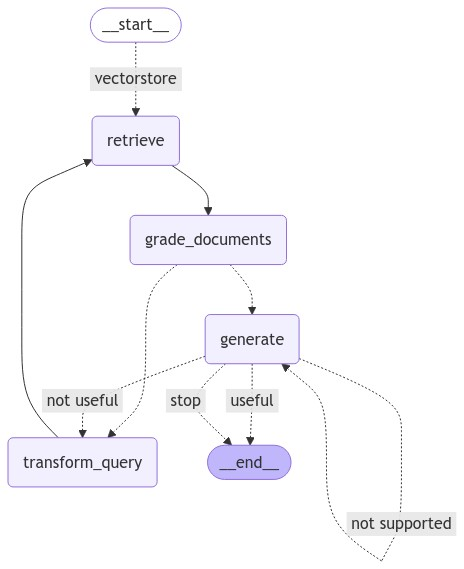


Processing question ID 0: How has Apple's total net sales changed over time?
---ROUTE QUESTION---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
Filtered Docs:  [Document(metadata={'id': '1xufm0HqxnnJCtK88AoDnNCuztVXuEVNb', 'lastModifyingUser': {'displayName': 'interiit.pathway.24', 'emailAddress': 'interiit.pathway.24@gmail.com', 'kind': 'drive#user', 'me': False, 'permissionId': '14505053473678289633', 'photoLink': 'https://lh3.googleusercontent.com/a-/ALV-UjW4hRisylyWntAeUYq0ONJbWcwFRK3NNE7qIyJSU0EQmEdaKA=s64'}, 'mimeType': 'application/pdf', 'modifiedTime': '2024-11-10T17:49:41.000Z', 'name': '2023 Q1 AAPL.pdf', 'parents': ['1eSyzlOwjM2PepzCuhL-UHfbRCfybopAX'], 'path': '2023 Q1 AAPL.pdf', 'seen_at': 1731267078, 'size': '377754', 'status': 'downloaded', 'thumbn

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import json
import time

def load_environment_variables():
    """Load environment variables from a .env file."""
    load_dotenv()
    os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
    os.environ["COHERE_API_KEY"] = os.getenv("COHERE_API_KEY")
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./credentials.json"
    os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
    os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

load_environment_variables()

from pprint import pprint
from typing import List

from agents.answer_grader import answer_grader
from agents.hallucination_grader import hallucination_grader
from agents.main_router import question_router
from agents.question_rewritter import question_rewriter
from agents.retrieval_grader import retrieval_grader
from langchain.schema import Document
from langgraph.graph import END, START, StateGraph
from rag.rag import (
    compress_documents,
    create_compressor,
    create_groq_llm,
    create_openai_llm,
    create_pathway_client,
    create_prompt_template,
    get_answer,
    retrieve_relevant_documents,
)
from tools.tools import web_search_tool
from typing_extensions import TypedDict

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

llm = create_openai_llm()
prompt = create_prompt_template()

# need to add this as a state value in workflow, havent done it yet
NOT_SUPPORTED_COUNTER = 0

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    revision_number: int
    max_revisions: int


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    retriever = create_pathway_client()
    compressor = create_compressor()
    documents = retrieve_relevant_documents(retriever, question)
    compressed_docs = compress_documents(retriever, question, compressor)
    return {"documents": compressed_docs, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    # generation = rag_chain.invoke({"context": documents, "question": question})
    generation = get_answer(documents, question, llm, prompt)
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    if state['revision_number'] == state['max_revisions']:
        print("----MAXIMUM REVISIONS REACHED, NOT FILTERING DOCUMENTS----")
        return {"documents": documents, "question": question}
    
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print("Revision Number: ", state['revision_number'])
    state["revision_number"] += 1
    print("Revision Number: ", state['revision_number'])
    return {"documents": documents, "question": better_question, "revision_number":state["revision_number"]}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]
    print("Filtered Docs: ", filtered_documents)
    
    if not filtered_documents and state["revision_number"] < state["max_revisions"]:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    print(state)
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({
                "question": question, "generation": generation
            })
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            if state["revision_number"] >= state["max_revisions"]:
                print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS AND THE REVISION COUNT EXCEEDED THE MAX REVISION, STOP---")
                return "stop"
            else:
                print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
                return "not useful"

    else:
        if state["revision_number"] >= state["max_revisions"]:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS AND THE REVISION COUNT EXCEEDED THE MAX REVISION, STOP---")
            return "stop"
        else:
            # Increment not_supported_counter
            global NOT_SUPPORTED_COUNTER
            NOT_SUPPORTED_COUNTER += 1
            if NOT_SUPPORTED_COUNTER >= 3:
                print("---DECISION: GENERATION NOT GROUNDED TOO MANY TIMES, STOPPING---")
                return "stop"
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
            return "not supported"


# Graph Compilation
load_environment_variables()

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
        "stop": END,
    },
)

# Compile
app = workflow.compile()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

file_path = 'AAPL_10Q_dataset/aapl_qna_data.csv'
data = pd.read_csv(file_path)

results = []
for idx, row in data.iterrows():
    question = row['Question']
    gt_answer = row.get('Answer', "Ground truth answer not provided")
    
    print(f"\nProcessing question ID {idx}: {question}")
    start_time = time.time()  # Start timing
    # answer, retrieved_docs = run_workflow(question)
    inputs = {
        "question": question,
        "revision_number": 0,  # Start with the first revision attempt
        "max_revisions": 3,  # Maximum allowed revisions
    }
    # this should go into inputs once it is added as a state in workflow
    NOT_SUPPORTED_COUNTER = 0
    
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint(value, indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])

    retrieved_context = [
        {"doc_id": doc.metadata.get("doc_id", "unknown"), "text": doc.page_content}
        for doc in value['documents']
    ]
    
    answer = value['generation']
    
    result = {
        "query_id": str(idx).zfill(3),
        "question": question,
        "gt_answer": gt_answer,
        "response": answer,
        "retrieved_context": retrieved_context
    }
    
    results.append(result)
    
    with open(f"openParse_self_rag/{str(idx).zfill(3)}.json", 'w') as f:
        json.dump({"results": [result]}, f, indent=4)
        
    # Calculate and print time taken for the query
    end_time = time.time()
    time_taken = end_time - start_time
    print("============================================")
    print(f"Time taken for query ID {idx}: {time_taken:.2f} seconds")
    print("============================================")
    

output_path = 'eval_results/selfRAG_openParser.json'
with open(output_path, 'w') as f:
    json.dump({"results": results}, f, indent=4)

print(f"Evaluation results saved to {output_path}")

In [19]:
import os
import json

# Define the directory containing the JSON files
directory = "/home/lalit/pathway/Pathway_chatbot/corrective_adaptive_rag_outputs"

# Initialize an empty list to hold all results
merged_results = []

# Loop through all files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".json"):
        filepath = os.path.join(directory, filename)
        
        # Open and load each JSON file
        with open(filepath, 'r') as file:
            data = json.load(file)
            # Append the 'results' list from each file to the merged_results list
            merged_results.extend(data.get("results", []))

# Create the final merged JSON structure
merged_data = {"results": merged_results}

# Define the output path for the merged JSON file
output_file = os.path.join("rag_results_gpt-4o-mini_rerank_top5_k10-nowebsearch-corrective_adaptive_rag.json")

# Save the merged data to the output file
with open(output_file, 'w') as outfile:
    json.dump(merged_data, outfile, indent=4)

print("Merging complete. Merged file saved as:", output_file)


Merging complete. Merged file saved as: rag_results_gpt-4o-mini_rerank_top5_k10-nowebsearch-corrective_adaptive_rag.json


### Our Parser

OpenAI LLM initialized.


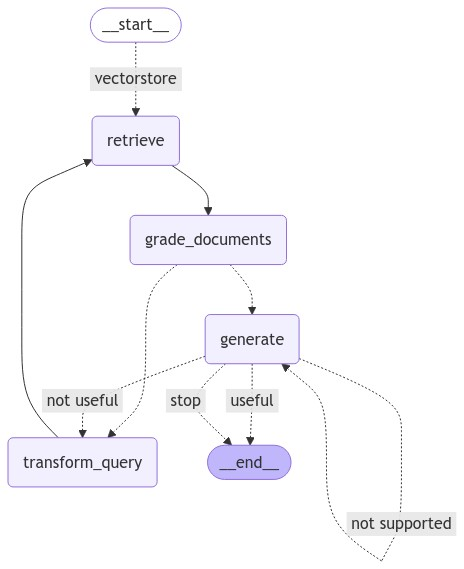


Processing question ID 0: How has Apple's total net sales changed over time?
---ROUTE QUESTION---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
Filtered Docs:  [Document(metadata={'element_id': 'a6abf9d098b989fa411186b3c5a97236', 'filename': 'files', 'filetype': 'application/pdf', 'id': '1xufm0HqxnnJCtK88AoDnNCuztVXuEVNb', 'languages': ['eng'], 'lastModifyingUser': {'displayName': 'interiit.pathway.24', 'emailAddress': 'interiit.pathway.24@gmail.com', 'kind': 'drive#user', 'me': False, 'permissionId': '14505053473678289633', 'photoLink': 'https://lh3.googleusercontent.com/a-/ALV-UjW4hRisylyWntAeUYq0ONJbWcwFRK3NNE7qIyJSU0EQmEdaKA=s64'}, 'mimeType': 'application/pdf', 'modifiedTime': '2024-11-10T17:49:41.000Z', 'name': '2023 Q1 AAPL.pdf', 'page_number': 20, 'parent

In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
import json
import time

def load_environment_variables():
    """Load environment variables from a .env file."""
    load_dotenv()
    os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
    os.environ["COHERE_API_KEY"] = os.getenv("COHERE_API_KEY")
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./credentials.json"
    os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
    os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

load_environment_variables()

from pprint import pprint
from typing import List

from agents.answer_grader import answer_grader
from agents.hallucination_grader import hallucination_grader
from agents.main_router import question_router
from agents.question_rewritter import question_rewriter
from agents.retrieval_grader import retrieval_grader
from langchain.schema import Document
from langgraph.graph import END, START, StateGraph
from rag.rag import (
    compress_documents,
    create_compressor,
    create_groq_llm,
    create_openai_llm,
    create_pathway_client,
    create_prompt_template,
    get_answer,
    retrieve_relevant_documents,
)
from tools.tools import web_search_tool
from typing_extensions import TypedDict

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

llm = create_openai_llm()
prompt = create_prompt_template()

# need to add this as a state value in workflow, havent done it yet
NOT_SUPPORTED_COUNTER = 0

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    revision_number: int
    max_revisions: int


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    retriever = create_pathway_client()
    compressor = create_compressor()
    documents = retrieve_relevant_documents(retriever, question)
    compressed_docs = compress_documents(retriever, question, compressor)
    return {"documents": compressed_docs, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    # generation = rag_chain.invoke({"context": documents, "question": question})
    generation = get_answer(documents, question, llm, prompt)
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    if state['revision_number'] == state['max_revisions']:
        print("----MAXIMUM REVISIONS REACHED, NOT FILTERING DOCUMENTS----")
        return {"documents": documents, "question": question}
    
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print("Revision Number: ", state['revision_number'])
    state["revision_number"] += 1
    print("Revision Number: ", state['revision_number'])
    return {"documents": documents, "question": better_question, "revision_number":state["revision_number"]}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]
    print("Filtered Docs: ", filtered_documents)
    
    if not filtered_documents and state["revision_number"] < state["max_revisions"]:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    print(state)
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({
                "question": question, "generation": generation
            })
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            if state["revision_number"] >= state["max_revisions"]:
                print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS AND THE REVISION COUNT EXCEEDED THE MAX REVISION, STOP---")
                return "stop"
            else:
                print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
                return "not useful"

    else:
        if state["revision_number"] >= state["max_revisions"]:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS AND THE REVISION COUNT EXCEEDED THE MAX REVISION, STOP---")
            return "stop"
        else:
            # Increment not_supported_counter
            global NOT_SUPPORTED_COUNTER
            NOT_SUPPORTED_COUNTER += 1
            if NOT_SUPPORTED_COUNTER >= 3:
                print("---DECISION: GENERATION NOT GROUNDED TOO MANY TIMES, STOPPING---")
                return "stop"
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
            return "not supported"


# Graph Compilation
load_environment_variables()

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
        "stop": END,
    },
)

# Compile
app = workflow.compile()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

file_path = 'AAPL_10Q_dataset/aapl_qna_data.csv'
data = pd.read_csv(file_path)

results = []
for idx, row in data.iterrows():
    question = row['Question']
    gt_answer = row.get('Answer', "Ground truth answer not provided")
    
    print(f"\nProcessing question ID {idx}: {question}")
    start_time = time.time()  # Start timing
    # answer, retrieved_docs = run_workflow(question)
    inputs = {
        "question": question,
        "revision_number": 0,  # Start with the first revision attempt
        "max_revisions": 3,  # Maximum allowed revisions
    }
    # this should go into inputs once it is added as a state in workflow
    NOT_SUPPORTED_COUNTER = 0
    
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint(value, indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])

    retrieved_context = [
        {"doc_id": doc.metadata.get("doc_id", "unknown"), "text": doc.page_content}
        for doc in value['documents']
    ]
    
    answer = value['generation']
    
    result = {
        "query_id": str(idx).zfill(3),
        "question": question,
        "gt_answer": gt_answer,
        "response": answer,
        "retrieved_context": retrieved_context
    }
    
    results.append(result)
    
    with open(f"enhancedParse_self_rag/{str(idx).zfill(3)}.json", 'w') as f:
        json.dump({"results": [result]}, f, indent=4)
        
    # Calculate and print time taken for the query
    end_time = time.time()
    time_taken = end_time - start_time
    print("============================================")
    print(f"Time taken for query ID {idx}: {time_taken:.2f} seconds")
    print("============================================")
    

output_path = 'eval_results/selfRAG_enhancedParser.json'
with open(output_path, 'w') as f:
    json.dump({"results": results}, f, indent=4)

print(f"Evaluation results saved to {output_path}")

### Unstructured HiRes Parser

OpenAI LLM initialized.


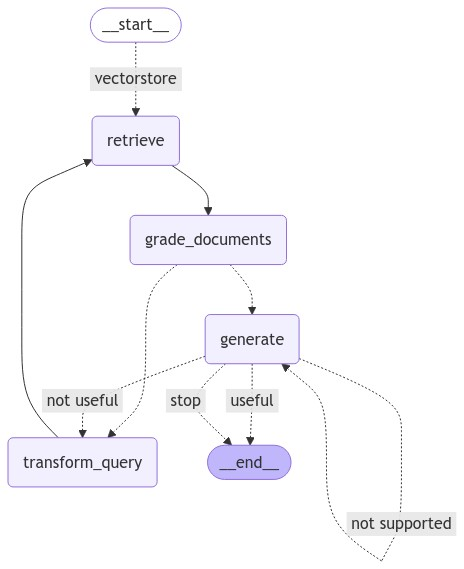


Processing question ID 0: How has Apple's total net sales changed over time?
---ROUTE QUESTION---
---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
Filtered Docs:  [Document(metadata={'element_id': 'baf68d2676175719556946ea0feeacf8', 'filename': 'files', 'filetype': 'application/pdf', 'id': '1iZxH861lrPVI2Uk2yaovgDbHcm0xQrrk', 'languages': ['eng'], 'lastModifyingUser': {'displayName': 'Rishikant Chigrupaatii', 'emailAddress': 'rishikantchigrupaatii.24@gmail.com', 'kind': 'drive#user', 'me': False, 'permissionId': '17173739234292623764', 'photoLink': 'https://lh3.googleusercontent.com/a-/ALV-UjU1KD47uYx6j38l6-BffzjqvFLMonawkgCXyTROQl88HaI7QH2D=s64'}, 'mimeType': 'application/pdf', 'modifiedTime': '2024-10-28T17:50:01.000Z', 'name': 'rk.pdf', 'page_number': 19, 'parent

In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import json
import time

def load_environment_variables():
    """Load environment variables from a .env file."""
    load_dotenv()
    os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
    os.environ["COHERE_API_KEY"] = os.getenv("COHERE_API_KEY")
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./credentials.json"
    os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
    os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

load_environment_variables()

from pprint import pprint
from typing import List

from agents.answer_grader import answer_grader
from agents.hallucination_grader import hallucination_grader
from agents.main_router import question_router
from agents.question_rewritter import question_rewriter
from agents.retrieval_grader import retrieval_grader
from langchain.schema import Document
from langgraph.graph import END, START, StateGraph
from rag.rag import (
    compress_documents,
    create_compressor,
    create_groq_llm,
    create_openai_llm,
    create_pathway_client,
    create_prompt_template,
    get_answer,
    retrieve_relevant_documents,
)
from tools.tools import web_search_tool
from typing_extensions import TypedDict

from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

llm = create_openai_llm()
prompt = create_prompt_template()

# need to add this as a state value in workflow, havent done it yet
NOT_SUPPORTED_COUNTER = 0

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
    revision_number: int
    max_revisions: int


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    retriever = create_pathway_client()
    compressor = create_compressor()
    documents = retrieve_relevant_documents(retriever, question)
    compressed_docs = compress_documents(retriever, question, compressor)
    return {"documents": compressed_docs, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    # generation = rag_chain.invoke({"context": documents, "question": question})
    generation = get_answer(documents, question, llm, prompt)
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    
    if state['revision_number'] == state['max_revisions']:
        print("----MAXIMUM REVISIONS REACHED, NOT FILTERING DOCUMENTS----")
        return {"documents": documents, "question": question}
    
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    print("Revision Number: ", state['revision_number'])
    state["revision_number"] += 1
    print("Revision Number: ", state['revision_number'])
    return {"documents": documents, "question": better_question, "revision_number":state["revision_number"]}


### Edges ###


def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    filtered_documents = state["documents"]
    print("Filtered Docs: ", filtered_documents)
    
    if not filtered_documents and state["revision_number"] < state["max_revisions"]:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    print(state)
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({
                "question": question, "generation": generation
            })
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            if state["revision_number"] >= state["max_revisions"]:
                print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS AND THE REVISION COUNT EXCEEDED THE MAX REVISION, STOP---")
                return "stop"
            else:
                print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
                return "not useful"

    else:
        if state["revision_number"] >= state["max_revisions"]:
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS AND THE REVISION COUNT EXCEEDED THE MAX REVISION, STOP---")
            return "stop"
        else:
            # Increment not_supported_counter
            global NOT_SUPPORTED_COUNTER
            NOT_SUPPORTED_COUNTER += 1
            if NOT_SUPPORTED_COUNTER >= 3:
                print("---DECISION: GENERATION NOT GROUNDED TOO MANY TIMES, STOPPING---")
                return "stop"
            print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
            return "not supported"


# Graph Compilation
load_environment_variables()

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
        "stop": END,
    },
)

# Compile
app = workflow.compile()

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

file_path = 'AAPL_10Q_dataset/aapl_qna_data.csv'
data = pd.read_csv(file_path)

results = []
for idx, row in data.iterrows():
    question = row['Question']
    gt_answer = row.get('Answer', "Ground truth answer not provided")
    
    print(f"\nProcessing question ID {idx}: {question}")
    start_time = time.time()  # Start timing
    # answer, retrieved_docs = run_workflow(question)
    inputs = {
        "question": question,
        "revision_number": 0,  # Start with the first revision attempt
        "max_revisions": 3,  # Maximum allowed revisions
    }
    # this should go into inputs once it is added as a state in workflow
    NOT_SUPPORTED_COUNTER = 0
    
    for output in app.stream(inputs):
        for key, value in output.items():
            # Node
            pprint(f"Node '{key}':")
            # Optional: print full state at each node
            # pprint(value, indent=2, width=80, depth=None)
        pprint("\n---\n")

    # Final generation
    pprint(value["generation"])

    retrieved_context = [
        {"doc_id": doc.metadata.get("doc_id", "unknown"), "text": doc.page_content}
        for doc in value['documents']
    ]
    
    answer = value['generation']
    
    result = {
        "query_id": str(idx).zfill(3),
        "question": question,
        "gt_answer": gt_answer,
        "response": answer,
        "retrieved_context": retrieved_context
    }
    
    results.append(result)
    
    with open(f"hiResParse_self_rag/{str(idx).zfill(3)}.json", 'w') as f:
        json.dump({"results": [result]}, f, indent=4)
        
    # Calculate and print time taken for the query
    end_time = time.time()
    time_taken = end_time - start_time
    print("============================================")
    print(f"Time taken for query ID {idx}: {time_taken:.2f} seconds")
    print("============================================")
    

output_path = 'eval_results/selfRAG_hiResParser.json'
with open(output_path, 'w') as f:
    json.dump({"results": results}, f, indent=4)

print(f"Evaluation results saved to {output_path}")